# Download images from the Google Earth Engine

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ee
ee.Initialize()
#ee.Authenticate()

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Import the folium library.
import folium
from folium import plugins
from branca.element import Template, MacroElement

import branca
import io
from PIL import Image

In [ ]:
# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [877]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True,
                show=False
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True,
                show=False
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True,
                show=False
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True,
                show=False
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [878]:
import config

#### Definition of datasets and regions

In [978]:
mode = 'region'
clip_geometry = config.AMAZON_ECOREGION
centroid =  clip_geometry.geometry().centroid().getInfo() 
zoom = 4.5


# mode = 'point'
# test_point = ee.Geometry.Point([-63.41974027942962,-9.247989737470059]) # used in thesis
# ##test_point = ee.Geometry.Point([-54.06552, -11.916899])
# ##test_point = ee.Geometry.Point([-55.104946 , -12.3078165]) # worst prediction point#
# clip_geometry = ee.FeatureCollection(test_point.buffer((30*256)/2).bounds())
# centroid =  test_point
# zoom = 13

In [979]:
def get_default_map():
    center = centroid['coordinates'][::-1]
    my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)
    return my_map

In [980]:
def get_png(my_map, crop_size = None):
    img_data = my_map._to_png(10)
    img = Image.open(io.BytesIO(img_data))
    if crop_size:
        img = img.crop(crop_size)
    else:
        img = img.crop((300, 40, img.width-260, img.height-10))
    return img

In [981]:
if mode == 'point':
    w,h = 480, 138
    crop_size = (w, h, w+407, h+407)
else:
    crop_size = None

def get_img_dict(my_map, title, hex_palette, vmin = None, vmax = None, cat_label = None, crop_size = crop_size):
    image_dict = {}
    image_dict['image'] = get_png(my_map, crop_size)
    image_dict['title'] = title
    image_dict['hex_palette'] = hex_palette
    if vmin is not None:
        image_dict['vmin'] = vmin
    if vmax is not None:
        image_dict['vmax'] = vmax
    if cat_label:
        image_dict['cat_label'] = cat_label
    
    return image_dict

In [982]:
feature_images = []

## Forest loss

In [983]:
### Distance to forest loss in the period of the first year in the range up to the second last year
first_forest_loss_year = 19
label_forest_loss_year = 19

forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED
                            .select(config.FOREST_IMAGE_BAND)
                            # Forest loss 19
                            .eq(19)
                            )

forest_loss_source_image = forest_loss_source_image.selfMask()


forest_loss = config.FOREST_LOSS_IMAGE_MASKED.updateMask(forest_loss_source_image)


hex_palette = ['#f03b20']

my_map = get_default_map()

my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(forest_loss.clip(clip_geometry), {'bands': ['lossyear'], 'min':13, 'max':19, 'palette': hex_palette}, 'forest loss')



template = """{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 100px; top: 70px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background-color:#f03b20;opacity:0.7;'></span>2019</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

my_map.get_root().add_child(macro)



my_map

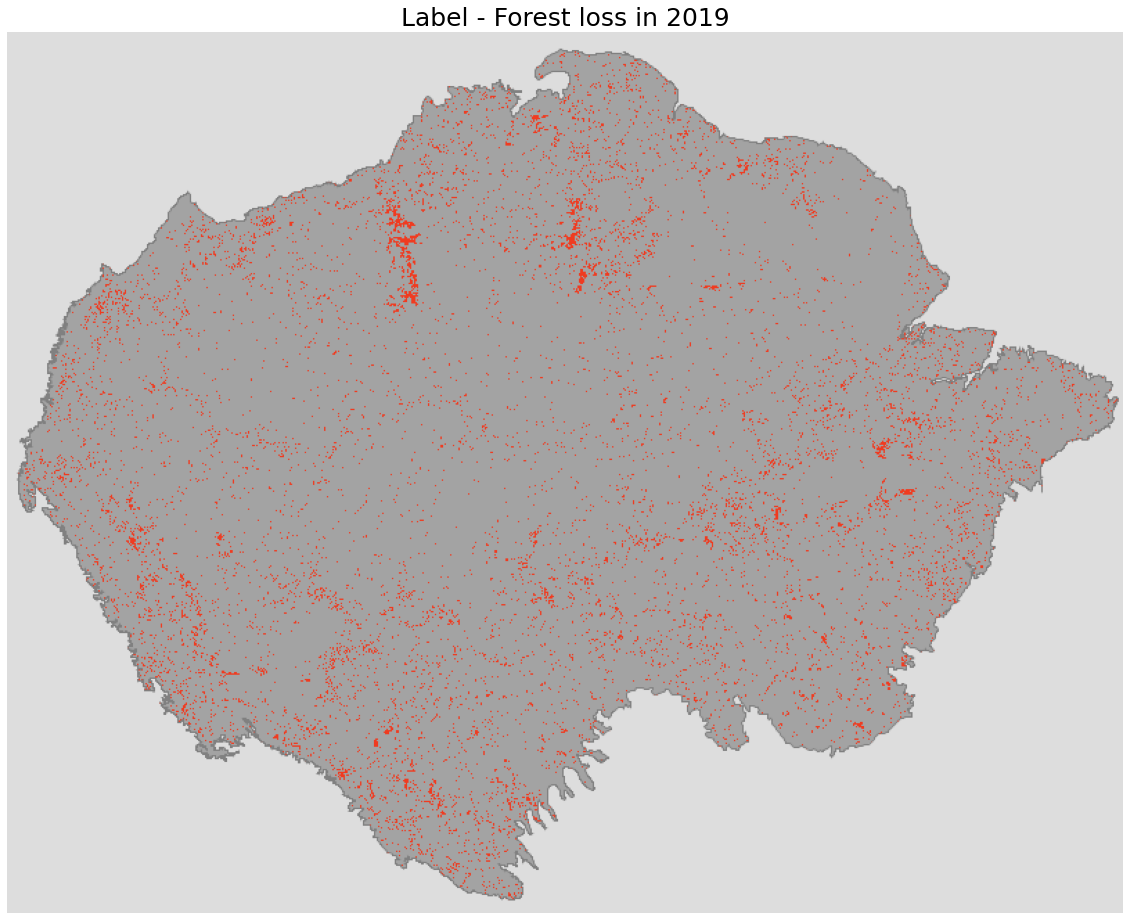

In [984]:
label_image_dict = get_img_dict(my_map, 'Label - Forest loss in 2019', hex_palette, 19, 19)
fig = plt.figure(figsize=(20,20))
plt.imshow(label_image_dict['image'])
plt.title(label_image_dict['title'], fontsize=25)
plt.axis('off')
plt.show()

## Population density

In [985]:
my_map = get_default_map()
pop_density_image = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").filterDate('2015-01-01', '2015-12-31').first().unmask(0);

# Set max distance param
if mode == 'region':
    vmin = 0
    vmax = 250
    num = 6
else:
    vmin = 0
    vmax = 40
    num = 6

colormap = branca.colormap.linear.YlOrRd_03.scale(vmin, vmax)
colormap = colormap.to_step(index=np.linspace(vmin, vmax, num=num))
colormap.caption = ''

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

my_map.add_ee_layer(pop_density_image.clip(clip_geometry), {  "palette": hex_palette,'min':vmin, 'max':vmax}, 'popu')


feature_images.append(get_img_dict(my_map, 'Population density (2015) (inhabitants per km2)', hex_palette, 0, vmax))
my_map

In [986]:
#gee = pop_density_image.clip(clip_geometry).sampleRectangle(clip_geometry).getInfo()
#max(gee['properties']['population_density']), min(gee['properties']['population_density'])

## Distance to cities

In [987]:
my_map = get_default_map()


# Define cost image, every pixel gets a cost of 1 attached
cost = ee.Image(1).toByte()

# Distance to population centre
# Mask city centres (more than 100 inhabitants per square kilometer)
city_centre_image = pop_density_image.gt(100).selfMask()

vmin = 0
# Set max distance param
if mode == 'region':
    vmax = 500
    max_dist  = vmax * 1000
    num = 6
else:
    vmax = 20
    max_dist  = vmax * 1000
    num = 5
    
# Compute the cumulative cost to the next source, in this case city centre
cost_to_city_centre = (cost.cumulativeCost(source=city_centre_image,
                                           maxDistance=max_dist
                                           )
                           .select('cumulative_cost').clip(clip_geometry))
colormap = branca.colormap.linear.YlOrRd_03.scale(vmin, vmax)
steps  = np.linspace(vmin, vmax, num=num).astype(int)
colormap = colormap.to_step(index=steps)
colormap.colors = colormap.colors[::-1]
colormap.caption = ''
#colormap.add_to(my_map)

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

my_map.add_ee_layer(cost_to_city_centre.clip(clip_geometry), {  "palette": hex_palette,'min':vmin, 'max':vmax*1000}, 'popu')

my_map.add_ee_layer(city_centre_image.clip(clip_geometry), {'color' :'grey', 'min':0, 'max':0 }, 'city centre')

feature_images.append(get_img_dict(my_map, 'Distance to next city (2015) (km)', hex_palette, 0, vmax))
my_map

## Distance to roads

In [988]:
my_map = get_default_map()

# Distance to roads        
roads_sources = ee.Image().toByte().paint(config.ROADS_AMAZON, 1)
# Mask the sources image with itself.
roads_sources = roads_sources.updateMask(roads_sources)
# Define band name
band_name = config.DIST_TO_ROADS_BAND
# Distance to roads
# Define cost image, every pixel gets a cost of 1 attached
cost = ee.Image(1).toByte()
# Compute the cumulative cost to traverse

# Set max distance param
if mode == 'region':
    max_dist  = 300 * 1000
    vmin = 0
    vmax = 300
    num = 7
else:
    vmax = 10
    max_dist  = vmax * 1000
    vmin = 0
    num = 6

dist_roads = (cost.cumulativeCost(source=roads_sources,
                                  maxDistance=max_dist
                                  )
                   .select('cumulative_cost')
                   .rename(band_name).clip(clip_geometry))

    


    
colormap = branca.colormap.linear.YlOrRd_03.scale(vmin, vmax)
steps  = np.linspace(vmin, vmax, num=num).astype(int)
colormap = colormap.to_step(index=steps)
colormap.caption = ''
colormap.colors = colormap.colors[::-1]
#colormap.add_to(my_map)
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]





my_map.add_ee_layer(dist_roads, {  "palette": hex_palette,
                                 'min':0, 'max':vmax*1000}, 'dist_to_roads')

my_map.add_ee_layer(config.ROADS_AMAZON.draw(color = 'black', strokeWidth= 1).clip(clip_geometry), {}, 'roads')

feature_images.append(get_img_dict(my_map, 'Distance to next road (km)', hex_palette, vmin, vmax))
my_map

## Elevation

In [989]:
my_map = get_default_map()
digital_elevation_image = config.DIGITAL_ELEVATION_IMAGE

vmin = 0
# Set max distance param
if mode == 'region':
    vmax = 3000
    num = 7
else:
    vmin = 0
    vmax = 150
    num = 6
    

colormap = branca.colormap.linear.Greys_07.scale(0, vmax)
steps  = np.linspace(vmin, vmax, num=num).astype(int)
colormap = colormap.to_step(index=steps)
colormap.caption = ''
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

my_map.add_ee_layer(digital_elevation_image.clip(clip_geometry), {'min':0, 'max':vmax, 'palette':hex_palette}, 'elev')

feature_images.append(get_img_dict(my_map, 'Elevation (m)', hex_palette, 0, vmax))
my_map

In [990]:
#gee = digital_elevation_image.clip(clip_geometry).sampleRectangle(clip_geometry).getInfo()
#max(gee['properties']['elevation']), min(gee['properties']['elevation'])

## Slope

In [994]:
my_map = get_default_map()
slope = ee.Terrain.slope(config.DIGITAL_ELEVATION_IMAGE).clip(clip_geometry)


colormap = branca.colormap.linear.Greys_07.scale(0, 60)
colormap = colormap.to_step(index=[0, 10, 20, 30, 40, 50, 60])
colormap.colors = colormap.colors[::-1]
colormap.caption = ''
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]


my_map.add_ee_layer(slope, {'min': 0, 'max': 60, 'palette':hex_palette}, 'slope')
feature_images.append(get_img_dict(my_map, 'Slope (°)', hex_palette, 0, 60))
my_map

## Treecover 2000

In [995]:
my_map = get_default_map()
treecover2000 = config.FOREST_LOSS_IMAGE_MASKED.select('treecover2000').clip(clip_geometry)


colormap = branca.colormap.linear.Greens_03.scale(0, 100)
colormap = colormap.to_step(index=[0, 20, 40, 60, 80, 100])
colormap.caption = ''
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]


my_map.add_ee_layer(treecover2000, {'min': 0, 'max': 100, 'palette':hex_palette}, 'treecover2000')
feature_images.append(get_img_dict(my_map, 'Treecover 2000 (%)', hex_palette, 0, 100))
my_map

## Previous deforestation

### Forest loss previous five years

In [996]:
### Distance to forest loss in the period of the first year in the range up to the second last year
first_forest_loss_year = 1
label_forest_loss_year = 19

forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED
                            .select(config.FOREST_IMAGE_BAND)
                            # Greater or equal than the first year
                            .gte(first_forest_loss_year) 
                            # Less than the last year
                            .And(config.FOREST_LOSS_IMAGE_MASKED.select(config.FOREST_IMAGE_BAND)
                            .lt(label_forest_loss_year)) 
                            )

forest_loss_source_image = forest_loss_source_image.selfMask()


forest_loss = config.FOREST_LOSS_IMAGE_MASKED.updateMask(forest_loss_source_image)

colormap = branca.colormap.linear.YlOrRd_03.scale(2001, 2020)
colormap = colormap.to_step(index=list(range(2001,2021)))
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors][:-1]
#hex_palette = ['#ffeda0', '#ffd57e', '#febe5d', '#fb9a43', '#f66b32', '#f03b20']


#hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]



my_map = get_default_map()

my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(forest_loss.clip(clip_geometry), {'bands': ['lossyear'], 'min':1, 'max':19, 'palette': hex_palette}, 'forest loss')


feature_images.append(get_img_dict(my_map, 'Previous deforestation (2001-2018)', hex_palette, vmin = 2001, vmax = 2018, cat_label = list(np.linspace(2002, 2018, num=9).astype(int))))
my_map

### Forest loss near proximity

In [997]:
## Distance to forest loss in the period of the first year in the range up to the second last year
first_forest_loss_year = 13
label_forest_loss_year = 19

forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED
                            .select(config.FOREST_IMAGE_BAND)
                            # Greater or equal than the first year
                            .gte(first_forest_loss_year) 
                            # Less than the last year
                            .And(config.FOREST_LOSS_IMAGE_MASKED.select(config.FOREST_IMAGE_BAND)
                            .lt(label_forest_loss_year)) 
                            )

forest_loss_source_image = forest_loss_source_image.selfMask()

# Compute the cumulative cost to the next source, in this case lost forest
band_name = config.DIST_TO_FOREST_BAND
cost_to_forest_loss= (cost.cumulativeCost(source=forest_loss_source_image,
                                            maxDistance=30 * 1000 # 100 kilometers
                                            )
                            .select('cumulative_cost')
                            .rename(band_name))


colormap = branca.colormap.linear.YlOrRd_03.scale(0, 8)
colormap = colormap.to_step(index=[0, 2, 4, 6, 8])
colormap.caption = ''


hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

# Create kernel     
lst = ee.List.repeat(1, 3)
lsts = ee.List.repeat(lst, 3)
kernel = ee.Kernel.fixed(3, 3, lsts)


forest_convole = forest_loss_source_image.updateMask(forest_loss_source_image).convolve(kernel).unmask(0)

my_map = get_default_map()
my_map.add_ee_layer(forest_convole.clip(clip_geometry), {'palette':hex_palette, 'min':0, 'max':8}, 'forest convolve')

feature_images.append(get_img_dict(my_map, 'Forest loss in neighboring cells (2013-2018)', hex_palette, 0, 8))
my_map

### Forest loss distance

In [998]:
## Distance to forest loss in the period of the first year in the range up to the second last year
first_forest_loss_year = 13
label_forest_loss_year = 19

forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED
                            .select(config.FOREST_IMAGE_BAND)
                            # Greater or equal than the first year
                            .gte(first_forest_loss_year) 
                            # Less than the last year
                            .And(config.FOREST_LOSS_IMAGE_MASKED.select(config.FOREST_IMAGE_BAND)
                            .lt(label_forest_loss_year)) 
                            )

forest_loss_source_image = forest_loss_source_image.selfMask()

# Compute the cumulative cost to the next source, in this case lost forest
band_name = config.DIST_TO_FOREST_BAND
vmin = 0
# Set max distance param
if mode == 'region':
    vmax = 30
    max_dist  = vmax * 1000
    num = 7
else:
    vmax = 5
    max_dist  = vmax * 1000
    num = 6
    
cost_to_forest_loss= (cost.cumulativeCost(source=forest_loss_source_image,
                                            maxDistance=max_dist# 100 kilometers
                                            )
                            .select('cumulative_cost')
                            .rename(band_name))


colormap = branca.colormap.linear.YlOrRd_03.scale(vmin, vmax)
colormap = colormap.to_step(index=np.linspace(vmin, vmax, num=num))
colormap.colors = colormap.colors[::-1]
colormap.caption = ''


hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

my_map = get_default_map()

my_map.add_ee_layer(cost_to_forest_loss.clip(clip_geometry), {  "palette": hex_palette,'min':0, 'max':vmax*1000}, 'dist_to_forest_loss')

feature_images.append(get_img_dict(my_map, 'Distance to next forest loss between 2013-2018 (km)', hex_palette, 0, vmax))
my_map

# Image grid

In [999]:
def show_img(fig, ax, image, hex_palette, vmin = None, vmax = None, cat_label = None):
    
    if hex_palette:
        if cat_label:
            newcmp = ListedColormap(hex_palette)
        else:
            newcmp = LinearSegmentedColormap.from_list('new', hex_palette, N=100)

    ax.imshow(image)
    
    # Create colorbar
    if vmin is not None: 
        # setup the normalization and the colormap
        normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
        colormap = newcmp


        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)   

        # setup the colorbar
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        fig.colorbar(scalarmappaple, cax=cax, orientation = 'horizontal', fraction=0.057, pad=0.04, ticks=cat_label).ax.tick_params(labelsize=20)
        
    

In [1000]:
def create_figure(width, heigth, ncols, nrows, feature_images):
    fig = plt.figure(figsize=(width,heigth))
    grid_spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

    # Plot
    i = 0
    for row in range(nrows):
        for col in range(ncols):
            if i < len(feature_images):
                feature_image = feature_images[i]

                title = feature_image['title']
                image = feature_image['image']
                hex_palette = feature_image['hex_palette']
                
                if 'vmin' in feature_image:
                    vmin = feature_image['vmin']
                    vmax = feature_image['vmax']
                else:
                    vmin = None
                    vmax = None
                ax = fig.add_subplot(grid_spec[row, col])
                ax.set_title(title, fontsize=25, wrap=True)
                ax.axis('off')
                if 'cat_label' in feature_image:
                    cat_label = feature_image['cat_label']
                else:
                    cat_label = None

                show_img(fig, ax, image, hex_palette, vmin, vmax, cat_label)
                i+=1


    fig.tight_layout()

    plt.show()
    return fig

In [1001]:
feature_images[0]['title'] = "Population density (2015) \n(inhabitants per km2)"
feature_images[-1]['title'] = "Distance to next forest loss \n(2013-2018) (km)"

In [1002]:
feature_images[-2]['title'] = "Forest loss in neighboring cells \n(2013-2018)"

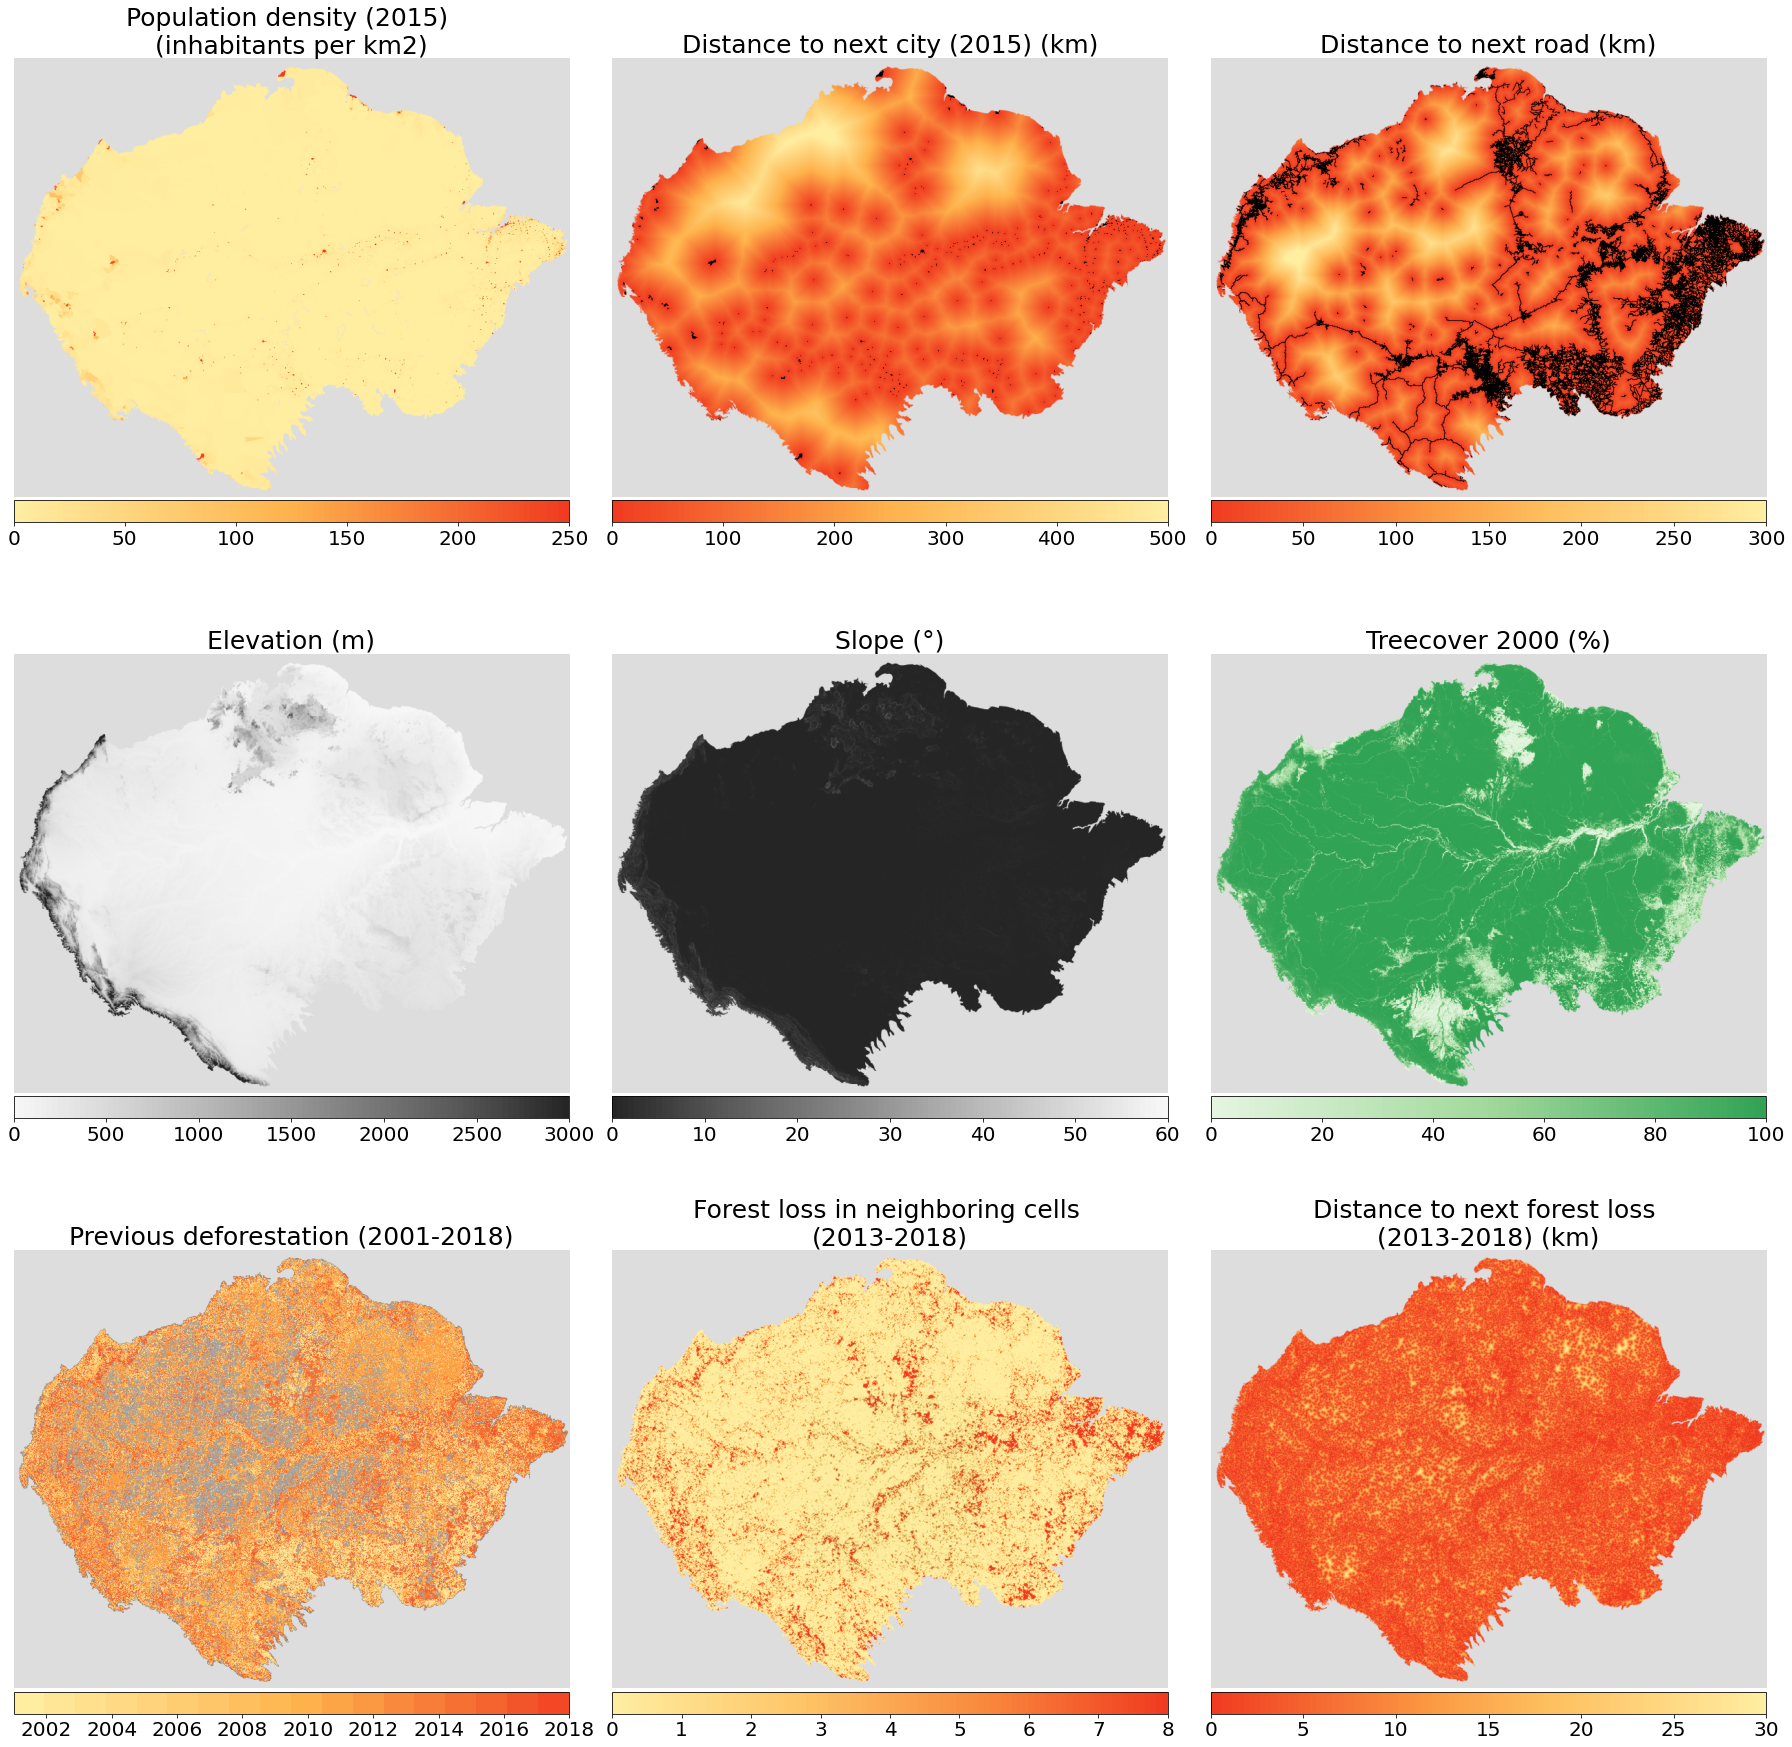

In [1003]:
# Generate image
baseline_features_fig = create_figure(25, 25, 3, 3, feature_images)

In [915]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [1004]:
baseline_features_fig.savefig('baseline_features.png')

In [977]:
point_feature_images # Saved for reuse

In [ ]:
#baseline_features_fig.savefig('baseline_features_point_worst_pred')

## Complete forest loss

In [ ]:
### Distance to forest loss in the period of the first year in the range up to the second last year

forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED
                            .select(config.FOREST_IMAGE_BAND)
                            )

forest_loss_source_image = forest_loss_source_image.selfMask()


forest_loss = config.FOREST_LOSS_IMAGE_MASKED.updateMask(forest_loss_source_image)

colormap = branca.colormap.linear.YlOrRd_03.scale(2000, 2019)

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]


#hex_palette = ['#ffeda0', '#ffd57e', '#febe5d', '#fb9a43', '#f66b32', '#f03b20']


treeLossVisParam = {
  'bands': ['lossyear'],
  'min': 0,
  'max': 19,
  'palette': ['yellow', 'red']
}

center = centroid['coordinates'][::-1]
my_map = folium.Map(location=center, zoom_start=zoom+3, tiles = "", zoom_control=False, height = 8000, width = 8000)


my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
#my_map.add_ee_layer(forest_loss.clip(clip_geometry), {'bands': ['lossyear'], 'min':0, 'max':19, 'palette': hex_palette}, 'forest loss')
my_map.add_ee_layer(forest_loss.clip(clip_geometry), treeLossVisParam, 'forest loss')

#feature_images.append(get_img_dict(my_map, 'Forest loss per year (2013-2019)', hex_palette, vmin = 2013, vmax = 2018, cat_label = [2013, 2014, 2015, 2016, 2017, 2018]))
my_map

In [ ]:
img = Image.open('all_loss_image.png')
colormap = branca.colormap.LinearColormap(colors=['yellow', 'red']).scale(2001, 2019)
colormap = colormap.to_step(index=np.linspace(2000, 2019, num=2019-2001))
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in colormap.colors]

all_loss_dict = {}
all_loss_dict['image'] = img
all_loss_dict['title'] = "Forest loss per year (2001-2019)"
all_loss_dict['cat_label'] = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
all_loss_dict['vmin'] = 2001
all_loss_dict['vmax'] = 2019
all_loss_dict['hex_palette'] = hex_palette

In [ ]:
# Generate label image
lbl_fig = create_figure(20, 20, 1, 1, [all_loss_dict])

In [ ]:
#lbl_fig.savefig('forest_loss_all_years.png')

## Satellite images

In [ ]:
def maskL8sr(image):
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
      qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
image = (l8sr
        .filterDate('2016-01-01', '2018-12-31')
        #.filterMetadata("CLOUD_COVER","less_than", 0.1) # filter cloudy images
        .map(maskL8sr) #Mask clouds
        .median() # Get median composite
        .select(list(config.LANDSAT8_BAND_MAPPING)) # Select bands
        .rename(list(config.LANDSAT8_BAND_MAPPING.values())    ) # Rename bands
        )




In [ ]:
satellite_images = []

In [ ]:

vmin = 0
vmax = 3000
gamma = 1.4
bands = ['RED', 'GREEN', 'BLUE']

my_map = get_default_map()
my_map.add_ee_layer(image.clip(clip_geometry), {'min':vmin, 'max':vmax, 'gamma':gamma, 'bands':bands}, 'RGB')

satellite_images.append(get_img_dict(my_map, 'RGB composite (2016-2018)', hex_palette, None, None))
my_map

In [ ]:
vmin = 0
vmax = 3000
gamma = 1.4
bands = ['NIR']

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in cm.viridis.colors]

my_map = get_default_map()
my_map.add_ee_layer(image.clip(clip_geometry), {'min':vmin, 'max':vmax, 'palette':hex_palette, 'bands':bands}, 'NIR')

satellite_images.append(get_img_dict(my_map, 'NIR composite (2016-2018)', hex_palette, 0.0, 0.3))
my_map

In [ ]:
vmin = 0
vmax = 3000
gamma = 1.4
bands = ['SWIR1']

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in cm.viridis.colors]

my_map = get_default_map()
my_map.add_ee_layer(image.clip(clip_geometry), {'min':vmin, 'max':vmax, 'palette':hex_palette, 'bands':bands}, 'SWIR1')

satellite_images.append(get_img_dict(my_map, 'SWIR1 composite (2016-2018)', hex_palette, 0.0, 0.3))
my_map

In [ ]:
vmin = 0
vmax = 3000
bands = ['SWIR2']

hex_palette = [matplotlib.colors.to_hex(list(color)) for color in cm.viridis.colors]

my_map = get_default_map()
my_map.add_ee_layer(image.clip(clip_geometry), {'min':vmin, 'max':vmax, 'palette':hex_palette, 'bands':bands}, 'SWIR2')

satellite_images.append(get_img_dict(my_map, 'SWIR2 composite (2016-2018)', hex_palette, 0.0, 0.3))
my_map

In [ ]:
# Generate image
satellite_features_fig = create_figure(20, 20, 2, 2, satellite_images)

In [ ]:
satellite_features_fig.savefig('satellite_composite')

## Continous split

In [ ]:
#test_point = ee.Geometry.Point([-63.41974027942962,-9.247989737470059])
clip_geometry = ee.FeatureCollection(test_point.buffer((30*256)/2).bounds())
centroid =  test_point
zoom = 13
center = centroid['coordinates'][::-1]
w,h = 480, 138
crop_size = (w, h, w+407, h+407)

In [ ]:
### Distance to forest loss in the period of the first year in the range up to the second last year


years = list(range(2013,2020))
hex_palette = ['#ffeda0', '#ffd57e', '#febe5d', '#fb9a43', '#f66b32', '#f03b20', '#f71818']
hex_palette_dict = dict(zip(years, hex_palette))


# create pictures
forest_images = []
for year, color in hex_palette_dict.items():
    forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED.eq(int(str(year)[-2:])))                         
    forest_loss_source_image = forest_loss_source_image.selfMask()
    forest_loss = config.FOREST_LOSS_IMAGE_MASKED.updateMask(forest_loss_source_image)



    my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)

    my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
    my_map.add_ee_layer(forest_loss.clip(clip_geometry), {'bands': ['lossyear'], 'palette': color}, 'forest loss')

    if year == years[-1]:
        name = f'Label - {year}'
    else:
        name = f'{year}'
        
    forest_images.append(get_img_dict(my_map, name, None, None, None, crop_size = crop_size))
    
yearly_sat_images = []
for year in years:
    #l8sr = config.get_landsat8_image(year)
    
    
    # rgb images
    vmin = 0
    vmax = 3000*0.0001
    gamma = 1.4
    bands = ['RED', 'GREEN', 'BLUE']

    my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)
    my_map.add_ee_layer(l8sr.clip(clip_geometry), {'min':vmin, 'max':vmax, 'gamma':gamma, 'bands':bands}, 'RGB')
    
    if year == years[-1]:
        name = f'{year}*'
    else:
        name = f'{year}'
        
    yearly_sat_images.append(get_img_dict(my_map, name, None, None, None, crop_size = crop_size))
        


In [ ]:
def create_figure(width, heigth, ncols, nrows, feature_images, no_lbl = False):
    fig = plt.figure(figsize=(width,heigth))
    grid_spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    
    
    if not no_lbl:
        font = {'size': 20}
        fig.text(0.0, 0.75, 'rgb', va='center', rotation='vertical', fontdict=font)
        fig.text(0.0, 0.25, 'forest loss', va='center', rotation='vertical', fontdict=font)


    # Plot
    i = 0
    for row in range(nrows):
        for col in range(ncols):
            if i < len(feature_images):
                feature_image = feature_images[i]

                title = feature_image['title']
                image = feature_image['image']
                hex_palette = feature_image['hex_palette']
                
                if 'vmin' in feature_image:
                    vmin = feature_image['vmin']
                    vmax = feature_image['vmax']
                else:
                    vmin = None
                    vmax = None
                ax = fig.add_subplot(grid_spec[row, col])
                ax.set_title(title, fontsize=20)
                ax.axis('off')
                if 'cat_label' in feature_image:
                    cat_label = feature_image['cat_label']
                else:
                    cat_label = None

                show_img(fig, ax, image, hex_palette, vmin, vmax, cat_label)
                i+=1


    fig.tight_layout()

    plt.show()
    return fig
    
# Generate image
fig = create_figure(20, 5, 7, 2, yearly_sat_images +  forest_images)

In [ ]:
yearly_sat_images[-1]['title'] = 2019

fig = create_figure(20, 10, 4, 2, yearly_sat_images, no_lbl=True)

In [ ]:
#fig.savefig('forest_loss_progression_sat_only.png')

In [ ]:
# Generate image
fig = create_figure(20, 5, 7, 2, yearly_sat_images +  forest_images)
fig.savefig('forest_loss_progression')

In [ ]:
# Generate image
sat_images_only = yearly_sat_images.copy()
sat_images_only[-1]['title'] = '2019'
fig = create_figure(20, 5, 7, 1, yearly_sat_images)
fig.savefig('forest_loss_progression_sat_only')

## More than rgb

In [ ]:
test_point = ee.Geometry.Point([-55.104946 , -12.3078165]) # From worst prediction
clip_geometry = ee.FeatureCollection(test_point.buffer((30*256)/2).bounds())
centroid =  test_point
zoom = 13
center = centroid['coordinates'][::-1]
w,h = 480, 138
crop_size = (w, h, w+407, h+407)

In [ ]:
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
ls8r_2019 = (l8sr
        .filterDate('2019-07-01', '2019-07-31')
        .map(maskL8sr) #Mask clouds
        .filterMetadata("CLOUD_COVER","less_than", 0.2) # filter cloudy images
        .median() # Get median composite
        .select(list(config.LANDSAT8_BAND_MAPPING)) # Select bands
        .rename(list(config.LANDSAT8_BAND_MAPPING.values())    ) # Rename bands
        )

ls8r_2019  = config.get_landsat8_image(2019)


In [ ]:
vmax = 3000

In [ ]:
hex_palette = [matplotlib.colors.to_hex(list(color)) for color in cm.viridis.colors]
my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)
my_map.add_ee_layer(ls8r_2019.clip(clip_geometry), {'min':vmin, 'max':vmax, 'palette':hex_palette, 'bands':'SWIR1'}, band)
my_map

In [ ]:
### Distance to forest loss in the period of the first year in the range up to the second last year


years = list(range(2013,2020))
hex_palette = ['#ffeda0', '#ffd57e', '#febe5d', '#fb9a43', '#f66b32', '#f03b20', '#f71818']
hex_palette_dict = dict(zip(years, hex_palette))


# create pictures
forest_images = []
for year, color in hex_palette_dict.items():
    forest_loss_source_image = (config.FOREST_LOSS_IMAGE_MASKED.eq(int(str(year)[-2:])))                         
    forest_loss_source_image = forest_loss_source_image.selfMask()
    forest_loss = config.FOREST_LOSS_IMAGE_MASKED.updateMask(forest_loss_source_image)



    my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)

    my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
    my_map.add_ee_layer(forest_loss.clip(clip_geometry), {'bands': ['lossyear'], 'palette': color}, 'forest loss')

    if year == years[-1]:
        name = f'Label - {year}'
    else:
        name = f'{year}'
        
    forest_images.append(get_img_dict(my_map, name, None, None, None, crop_size = crop_size))
    
yearly_sat_images = []
for year in years:
    
    if year == 2019:
        l8sr = ls8r_2019
    else:
        l8sr = config.get_landsat8_image(year)
    # rgb images
    vmin = 0
    vmax = 3000*0.0001
    gamma = 1.4
    bands = ['RED', 'GREEN', 'BLUE']

    my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)
    my_map.add_ee_layer(l8sr.clip(clip_geometry), {'min':vmin, 'max':vmax, 'gamma':gamma, 'bands':bands}, 'RGB')
    
    if year == years[-1]:
        name = f'{year}*'
    else:
        name = f'{year}'
        
    yearly_sat_images.append(get_img_dict(my_map, name, None, None, None, crop_size = crop_size))
  


In [ ]:
advanced_yearly_sat_images = []
bands = ['NIR', 'SWIR1', 'SWIR2']
for band in bands:
    for year in years:
        if year == 2019:
            l8sr = ls8r_2019
        else:
            l8sr = config.get_landsat8_image(year)
        # rgb images
        vmin = 0
        vmax = 3000*0.0001
        gamma = 1.4

        hex_palette = [matplotlib.colors.to_hex(list(color)) for color in cm.viridis.colors]

        my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)
        my_map.add_ee_layer(l8sr.clip(clip_geometry), {'min':vmin, 'max':vmax, 'palette':hex_palette, 'bands':band}, band)
 
        if year == years[-1]:
            name = f'{year}*'
        else:
            name = f'{year}'

        advanced_yearly_sat_images.append(get_img_dict(my_map, name, None, None, None, crop_size = crop_size))

In [ ]:
def create_figure(width, heigth, ncols, nrows, feature_images):
    fig = plt.figure(figsize=(width,heigth))
    grid_spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    
    font = {'size': 20}
    
    fig.text(-0.015, 0.65/6, 'NIR', va='center', rotation='vertical', fontdict=font)
    fig.text(-0.015, 1.755/6, 'SWIR2', va='center', rotation='vertical', fontdict=font)
    fig.text(-0.015, 3/6, 'SWIR1', va='center', rotation='vertical', fontdict=font)
    fig.text(-0.015, 4.15/6, 'RGB', va='center', rotation='vertical', fontdict=font)
    fig.text(-0.015, 10.6/12, 'Forest Loss', va='center', rotation='vertical', fontdict=font)

    # first lbl 
    first_lbl = True
    # Plot
    i = 0
    for row in range(nrows):
        
        for col in range(ncols):
            if i < len(feature_images):
                feature_image = feature_images[i]

                title = feature_image['title']
                image = feature_image['image']
                hex_palette = feature_image['hex_palette']
                
                if 'vmin' in feature_image:
                    vmin = feature_image['vmin']
                    vmax = feature_image['vmax']
                else:
                    vmin = None
                    vmax = None
                ax = fig.add_subplot(grid_spec[row, col])
                
                if first_lbl:
                    ax.set_title(title, fontsize=20)
                ax.axis('off')
                if 'cat_label' in feature_image:
                    cat_label = feature_image['cat_label']
                else:
                    cat_label = None

                show_img(fig, ax, image, hex_palette, vmin, vmax, cat_label)
                i+=1
        first_lbl = False

    fig.tight_layout()

    plt.show()
    return fig
    

In [ ]:
advanced_yearly_sat_images[0]['title']

In [ ]:
# Generate image
fig = create_figure(15, 12, 7, 5, forest_images + yearly_sat_images + advanced_yearly_sat_images)
#fig.savefig('forest_loss_progression_all')

fig.savefig('forest_loss_progression_flop_point', bbox_inches='tight')

### Assemble overlap

In [ ]:
def assemble_overlap(width, heigth, ncols, nrows, feature_images):
    fig = plt.figure(figsize=(width,heigth))
    grid_spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    
    # Plot
    i = 0
    for row in range(nrows):
        for col in range(ncols):
            if i < len(feature_images):
                feature_image = feature_images[i]

                title = feature_image['title']
                image = feature_image['image']
                hex_palette = feature_image['hex_palette']
                
                if 'vmin' in feature_image:
                    vmin = feature_image['vmin']
                    vmax = feature_image['vmax']
                else:
                    vmin = None
                    vmax = None
                ax = fig.add_subplot(grid_spec[row, col])
                ax.axis('off')
                if 'cat_label' in feature_image:
                    cat_label = feature_image['cat_label']
                else:
                    cat_label = None

                show_img(fig, ax, image, hex_palette, vmin, vmax, cat_label)
                i+=1


    fig.tight_layout(pad = -2)

    plt.show()
    return fig
    

In [ ]:
all_images = forest_images + yearly_sat_images + advanced_yearly_sat_images


all_image_dict = {}
for image_dict in all_images:
    image = image_dict['image']
    year = image_dict['title']
    
    if year not in all_image_dict:
        all_image_dict[year] = []
    
    all_image_dict[year].append(image)

all_image_dict

In [ ]:
import operator
from PIL import Image
from PIL import ImageDraw

for key,images in all_image_dict.items():
    # suppose img2 is to be shifted by `shift` amount 
    shift = np.array([25, 25])

    img_count = 5
    
    # Stacked img rev
    new_image = Image.new('RGBA', size=(407+shift[0]*img_count, 407+shift[1]*img_count), color=(0, 0, 0, 0))
    images_sorted = images[::-1]
    images_sorted = [images_sorted[-1]] + images_sorted[:-1]
    for i, img in enumerate(images_sorted):
        new_image.paste(img, tuple(list(shift*i)))
        key = key.replace("*", "")
        new_image.save(f'stacked_img_rev_{key}.png')
    
    # Stacked img 
    images_sorted = images[::-1]                                                  
    new_image = Image.new('RGBA', size=(407+shift[0]*img_count, 407+shift[1]*img_count), color=(0, 0, 0, 0))
    for i, img in enumerate(images_sorted):
        new_image.paste(img, tuple(list(shift*i)))
        key = key.replace("*", "")
        new_image.save(f'stacked_img_{key}.png')
        
    
    # Stacked without label 
    images_sorted = images[:-1] 
    new_image = Image.new('RGBA', size=(407+shift[0]*img_count, 407+shift[1]*img_count), color=(0, 0, 0, 0))
    for i, img in enumerate(images_sorted):
        new_image.paste(img, tuple(list(shift*i)))
        key = key.replace("*", "")
        new_image.save(f'stacked_img_without_lbl_{key}.png')
        

In [ ]:

current_img = all_image_dict['2013'][0]
for img in all_image_dict['2013'][1:]:
    # compute the size of the panorama
    nw, nh = map(max, map(operator.add, img.size, shift), current_img.size)
    
    # paste img1 on top of img2
    newimg1 = Image.new('RGBA', size=(nw, nh), color=(0, 0, 0, 0))
    newimg1.paste(img2, shift)
    newimg1.paste(img1, (0, 0))
    
    

In [ ]:
yearly_sat_images[0]['image'], advanced_yearly_sat_images[0]['image']

In [ ]:
fig = assemble_overlap(15, 12, 7, 5, forest_images + yearly_sat_images + advanced_yearly_sat_images)

In [ ]:
plt.imshow(yearly_sat_images[0]['image'])

In [ ]:
forest_images[0]['image'].height

In [ ]:
# Random points between 50000 and 51000
x, y = 1000 * np.random.random((2, 10)) + 50000

# A 10x10 "image"...
image = np.arange(100).reshape((10,10))

# In a lot of cases, image data will be "flipped" vertically, so you may need 
# use the `origin` kwarg, as well (or just swap the ymin and ymax ordering).
plt.imshow(image, extent=[x.min(), x.max(), y.min(), y.max()])
plt.plot(x, y, 'ro')

plt.show()

## Train, val, test split 

In [ ]:
split_feature = 'users/thex/dataset_split/stratified_%s_2013_2019' 
clip_geometry = config.DEFOREST_HOTSPOTS

# ecoregion
split_feature = 'users/thex/dataset_split_ecoregion/stratified_%s_2013_2019_ecoregion'
clip_geometry = config.AMAZON_ECOREGION

centroid =  clip_geometry.geometry().centroid().getInfo() 
zoom = 4.5
center = centroid['coordinates'][::-1]
center[0]-=3
my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)

train_poly = ee.FeatureCollection(split_feature%'train')
val_poly = ee.FeatureCollection(split_feature%'val')
test_poly = ee.FeatureCollection(split_feature%'test')


my_map.add_ee_layer(clip_geometry.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(train_poly.draw(color = 'blue', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(val_poly.draw(color = 'green', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(test_poly.draw(color = 'red', strokeWidth= 1), {}, 'drawn')

#satellite_images.append(get_img_dict(my_map, 'SWIR2 composite (2016-2018)', hex_palette, vmin, vmax))
my_map

In [ ]:
img_data = my_map._to_png(10)
img = Image.open(io.BytesIO(img_data))
test_img = img.crop((300, 70, img.width-285, img.height-50))

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


legend_patches = []
legend_patches.append(mpatches.Patch(color='blue', label='train'))
legend_patches.append(mpatches.Patch(color='green', label='val'))
legend_patches.append(mpatches.Patch(color='red', label='test'))

fig = plt.figure(figsize=(20,20))
plt.imshow(test_img)
plt.title('Train, test, val split', fontsize=25)
plt.axis('off')
plt.legend(handles=legend_patches, prop={'size':30})
plt.show()
fig.savefig('train_test_val split')

In [ ]:
test_point = ee.Geometry.Point([-53.41974027942962,-9.247989737470059])
clip_geometry = ee.FeatureCollection(test_point.buffer((30*256)/2).bounds())
centroid =  test_point
center = centroid['coordinates'][::-1]
center[0]-=1
zoom = 11

my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)

train_poly = ee.FeatureCollection('users/thex/dataset_split/stratified_train_2013_2019')
val_poly = ee.FeatureCollection('users/thex/dataset_split/stratified_val_2013_2019')
test_poly = ee.FeatureCollection('users/thex/dataset_split/stratified_test_2013_2019')

my_map.add_ee_layer(config.DEFOREST_HOTSPOTS.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(train_poly.draw(color = 'blue', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(val_poly.draw(color = 'green', strokeWidth= 1), {}, 'drawn')
my_map.add_ee_layer(test_poly.draw(color = 'red', strokeWidth= 1), {}, 'drawn')

#satellite_images.append(get_img_dict(my_map, 'SWIR2 composite (2016-2018)', hex_palette, vmin, vmax))
my_map

In [ ]:
img_data = my_map._to_png(10)
img = Image.open(io.BytesIO(img_data))
test_img = img.crop((300, 70, img.width-285, img.height-50))


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


legend_patches = []
legend_patches.append(mpatches.Patch(color='blue', label='train'))
legend_patches.append(mpatches.Patch(color='green', label='val'))
legend_patches.append(mpatches.Patch(color='red', label='test'))

fig = plt.figure(figsize=(20,20))
plt.imshow(test_img)
plt.title('Train, test, val split', fontsize=25)
plt.axis('off')
plt.legend(handles=legend_patches, prop={'size':30})
plt.show()
fig.savefig('train_test_val split_mini')

# Overview

In [ ]:
clip_geometry = config.AMAZON_ECOREGION
centroid =  clip_geometry.geometry().centroid().getInfo() 
zoom = 4
center = centroid['coordinates'][::-1]
center[0]-=0
my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)

my_map.add_ee_layer(config.DEFOREST_HOTSPOTS.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')

my_map

In [ ]:
img_data = my_map._to_png(10)
img = Image.open(io.BytesIO(img_data))
w,h = 400,145
img = img.crop((w, h, w+500, h+400))

fig = plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(img)

fig.savefig('deforest_hotspots')

In [ ]:
clip_geometry = config.AMAZON_ECOREGION
centroid =  clip_geometry.geometry().centroid().getInfo() 
zoom = 4
center = centroid['coordinates'][::-1]
center[0]-=0
my_map = folium.Map(location=center, zoom_start=zoom, tiles = "", zoom_control=False, height = 900)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)

my_map.add_ee_layer(config.AMAZON_ECOREGION.draw(color = 'grey', strokeWidth= 1), {}, 'drawn')

my_map

In [ ]:
img_data = my_map._to_png(10)
img = Image.open(io.BytesIO(img_data))
w,h = 400,250
img = img.crop((w, h, w+500, h+400))

fig = plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(img)
fig.savefig('amazon_ecoregion')